# Univariate Neural Network Speed Predictions Training Portal E4S 58.140

# Imports of Libraries and Datasets

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
!pip install tensorflow
!pip install tensorflow[and-cuda]
!pip install keras-tuner --upgrade
import keras_tuner as kt

zsh:1: no matches found: tensorflow[and-cuda]


In [4]:
#project_path = '/content/gdrive/MyDrive/Samhällsbyggnadsprogrammet/AH2179/Project/' # set your own project path
#df=pd.read_csv(project_path+'preprocessingV4.csv',sep=';') #Jennifers path
#project_path = '/content/gdrive/MyDrive/Project Applied AI/Data/' #Linneas path
train_df=pd.read_csv('/Users/algotsjoholm/Downloads/preprocessingV5.csv',sep=';')
train_df = train_df.dropna()

In [5]:
eval_df=pd.read_csv('/Users/algotsjoholm/Downloads/evalpreproV3.csv',sep=';') #change
eval_df = eval_df.dropna()
eval_df.describe()
eval_df = eval_df[eval_df['PORTAL'] == 'E4S 58,140']

In [6]:
train_df
train_df = train_df[train_df['PORTAL'] == 'E4S 58,140']
#train_df  = train_df[(train_df['Interval_1'] > 450) & (train_df['Interval_1'] <=510)]

In [7]:
peak_eval_df=pd.read_csv('/Users/algotsjoholm/Downloads/peakevalpreproV2.csv',sep=';') #change
peak_eval_df = peak_eval_df.dropna()
peak_eval_df
peak_eval_df = peak_eval_df[peak_eval_df['PORTAL'] == 'E4S 58,140']

# Model Creation

## Features and Normalization

In [8]:
features = [
    'FLOW_NEXT_15_SUM',
    'SPEED_NEXT_15_AVG',
    'FLOW_SUM',
    'SPEED_WEIGHTED_AVG',
    'FLOW_PREV_5_SUM',
    'FLOW_PREV_15_SUM',
    'FLOW_PREV_60_SUM',
    'SPEED_PREV_5_AVG',
    'SPEED_PREV_15_AVG',
    'SPEED_PREV_60_AVG',
    'IS_WEEKDAY',
    'Interval_30'
]

train_df = train_df[features]
#train_df = train_df.iloc[:30000]

x = train_df.drop(['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG'], axis=1)

#y = train_df[['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG']]
y = train_df['SPEED_NEXT_15_AVG']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)


scaler_y = StandardScaler()
#y_train = scaler_y.fit_transform(y_train)
#y_test = scaler_y.transform(y_test)

## Find Best Hyperparameters

In [9]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    
    model.add(Dense(units=hp.Choice('l1_units', values=[32, 64, 128, 256]), 
                    activation=hp.Choice('activation_1', ['relu', 'tanh']),
                    input_dim=X_train.shape[1]))

    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(Dense(units=hp.Choice(f'l{i+2}_units', values=[32, 64, 128, 256]),
                        activation=hp.Choice(f'activation_{i+2}', ['relu', 'tanh'])))
        #model.add(Dropout(rate=hp.Choice(f'dropout_{i+2}', values=[0.0, 0.2])))

    #model.add(Dense(2))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='mae',
        metrics=['mae']
    )

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_mae',
                     max_epochs=50,
                     factor=3,
                     seed=42,
                     directory='my_dir',
                     project_name='tune_exponential_units3')

early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stop, reduce_lr])

Reloading Tuner from my_dir/tune_exponential_units3/tuner0.json


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

l1_units: 64
activation_1: tanh
num_layers: 2
l2_units: 256
activation_2: relu
learning_rate: 0.002269730362400285
l3_units: 128
activation_3: tanh
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0080


## Train Best Model

In [11]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stop, reduce_lr])

Epoch 1/50


/Users/algotsjoholm/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - loss: 1.9119 - mae: 1.9119 - val_loss: 0.9542 - val_mae: 0.9542 - learning_rate: 0.0023
Epoch 2/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - loss: 0.9174 - mae: 0.9174 - val_loss: 0.3734 - val_mae: 0.3734 - learning_rate: 0.0023
Epoch 3/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - loss: 0.3676 - mae: 0.3676 - val_loss: 0.3230 - val_mae: 0.3230 - learning_rate: 0.0023
Epoch 4/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - loss: 0.3193 - mae: 0.3193 - val_loss: 0.3271 - val_mae: 0.3271 - learning_rate: 0.0023
Epoch 5/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step - loss: 0.3182 - mae: 0.3182 - val_loss: 0.3080 - val_mae: 0.3080 - learning_rate: 0.0023
Epoch 6/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - loss: 0.3054 - mae: 0.3054 - val_loss: 0.3027 - val_mae: 0.3027 - learning_rate: 0.0023
Epoch 7/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - loss: 0.3101 - mae: 0.3101 - val_loss: 0.2911 - val_mae: 0.2911 - learning_ra

Epoch 46/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - loss: 0.2529 - mae: 0.2529 - val_loss: 0.2600 - val_mae: 0.2600 - learning_rate: 7.0929e-05
Epoch 47/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - loss: 0.2523 - mae: 0.2523 - val_loss: 0.2588 - val_mae: 0.2588 - learning_rate: 7.0929e-05
Epoch 48/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - loss: 0.2523 - mae: 0.2523 - val_loss: 0.2591 - val_mae: 0.2591 - learning_rate: 7.0929e-05
Epoch 49/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - loss: 0.2487 - mae: 0.2487 - val_loss: 0.2598 - val_mae: 0.2598 - learning_rate: 7.0929e-05
Epoch 50/50
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - loss: 0.2525 - mae: 0.2525 - val_loss: 0.2616 - val_mae: 0.2616 - learning_rate: 7.0929e-05


In [12]:
pd.DataFrame(history.history)

,loss,mae,val_loss,val_mae,learning_rate
0,1.133390,1.133390,0.954182,0.954182,0.002270
1,0.781241,0.781241,0.373440,0.373440,0.002270
2,0.343650,0.343650,0.322974,0.322974,0.002270
3,0.314284,0.314284,0.327065,0.327065,0.002270
4,0.314902,0.314902,0.307976,0.307976,0.002270
5,0.306896,0.306896,0.302749,0.302749,0.002270
6,0.303750,0.303750,0.291099,0.291099,0.002270
7,0.304850,0.304850,0.289177,0.289177,0.002270
8,0.300125,0.300125,0.306914,0.306914,0.002270
9,0.296636,0.296636,0.292209,0.292209,0.002270


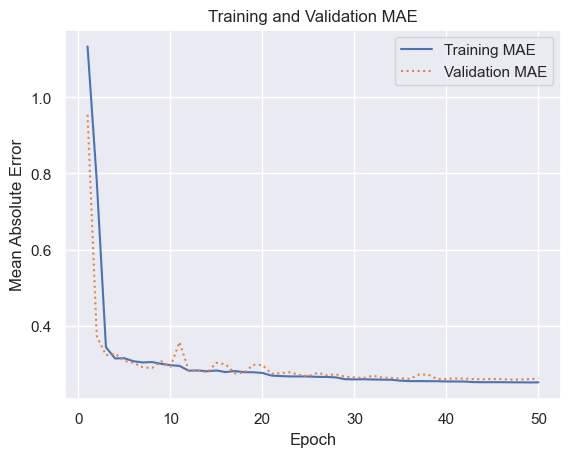

In [13]:
sns.set()

err = history.history['mae']
val_err = history.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.show()

# Evaluation Results

## Evaluation on Test Split

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)

#y_pred = scaler_y.inverse_transform(y_pred)
#y_test = scaler_y.inverse_transform(y_test)

'''mae_1 = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mse_1 = mean_squared_error(y_test[:, 0], y_pred[:, 0])
r2_1 = r2_score(y_test[:, 0], y_pred[:, 0])

# Calculate metrics for the second target variable (e.g., SPEED_NEXT_15_AVG)
mae_2 = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mse_2 = mean_squared_error(y_test[:, 1], y_pred[:, 1])
r2_2 = r2_score(y_test[:, 1], y_pred[:, 1])

# Optionally, calculate the overall mean of the MAE, MSE, and R^2 across both outputs
mae_avg = (mae_1 + mae_2) / 2
mse_avg = (mse_1 + mse_2) / 2
r2_avg = (r2_1 + r2_2) / 2

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")
print()
print(f"Target 2 - Mean Absolute Error (MAE): {mae_2}")
print(f"Target 2 - Mean Squared Error (MSE): {mse_2}")
print(f"Target 2 - R-squared (R^2): {r2_2}")
print()
print(f"Average MAE: {mae_avg}")
print(f"Average MSE: {mse_avg}")
print(f"Average R-squared: {r2_avg}")'''

mae_1 = mean_absolute_error(y_test, y_pred)
mse_1 = mean_squared_error(y_test, y_pred)
r2_1 = r2_score(y_test, y_pred)

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")


377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
--------------------------------------Result from the best model on test data ---------------------------------------------
Target 1 - Mean Absolute Error (MAE): 0.2560707880181905
Target 1 - Mean Squared Error (MSE): 0.2463999776979981
Target 1 - R-squared (R^2): 0.8664056376873164


## Evaluation on Full Final Evaluation Dataset

In [15]:
eval_df = eval_df[features]

x_eval = eval_df.drop(['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG'], axis=1)
#y_eval = eval_df[['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG']]
y_eval = eval_df['SPEED_NEXT_15_AVG']

x_eval = scaler_x.transform(x_eval)

y_pred = best_model.predict(x_eval)

#y_pred = scaler_y.inverse_transform(y_pred)
#y_eval = scaler_y.inverse_transform(y_eval)

'''mae_1 = mean_absolute_error(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])
mse_1 = mean_squared_error(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])
r2_1 = r2_score(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])

# Calculate metrics for the second target variable (e.g., SPEED_NEXT_15_AVG)
mae_2 = mean_absolute_error(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])
mse_2 = mean_squared_error(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])
r2_2 = r2_score(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])

# Optionally, calculate the overall mean of the MAE, MSE, and R^2 across both outputs
mae_avg = (mae_1 + mae_2) / 2
mse_avg = (mse_1 + mse_2) / 2
r2_avg = (r2_1 + r2_2) / 2

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")
print()
print(f"Target 2 - Mean Absolute Error (MAE): {mae_2}")
print(f"Target 2 - Mean Squared Error (MSE): {mse_2}")
print(f"Target 2 - R-squared (R^2): {r2_2}")
print()
print(f"Average MAE: {mae_avg}")
print(f"Average MSE: {mse_avg}")
print(f"Average R-squared: {r2_avg}")'''

mae_1 = mean_absolute_error(y_eval, y_pred)
mse_1 = mean_squared_error(y_eval, y_pred)
r2_1 = r2_score(y_eval, y_pred)

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")


798/798 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
--------------------------------------Result from the best model on test data ---------------------------------------------
Target 1 - Mean Absolute Error (MAE): 0.36446011207662043
Target 1 - Mean Squared Error (MSE): 0.6136124591216374
Target 1 - R-squared (R^2): 0.7499396444218905


## Evaluation on Peak Final Evaluation Dataset

In [16]:
eval_df_peak= peak_eval_df[features]

x_eval = eval_df_peak.drop(['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG'], axis=1)
#y_eval = eval_df_peak[['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG']]
y_eval = eval_df_peak['SPEED_NEXT_15_AVG']

x_eval = scaler_x.transform(x_eval)

#y_pred = scaler_y.inverse_transform(y_pred)
#y_eval = scaler_y.inverse_transform(y_eval)

y_pred = best_model.predict(x_eval)

'''mae_1 = mean_absolute_error(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])
mse_1 = mean_squared_error(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])
r2_1 = r2_score(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])

# Calculate metrics for the second target variable (e.g., SPEED_NEXT_15_AVG)
mae_2 = mean_absolute_error(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])
mse_2 = mean_squared_error(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])
r2_2 = r2_score(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")
print()
print(f"Target 2 - Mean Absolute Error (MAE): {mae_2}")
print(f"Target 2 - Mean Squared Error (MSE): {mse_2}")
print(f"Target 2 - R-squared (R^2): {r2_2}")
print()
print(f"Average MAE: {mae_avg}")
print(f"Average MSE: {mse_avg}")
print(f"Average R-squared: {r2_avg}")'''

mae_1 = mean_absolute_error(y_eval, y_pred)
mse_1 = mean_squared_error(y_eval, y_pred)
r2_1 = r2_score(y_eval, y_pred)

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
--------------------------------------Result from the best model on test data ---------------------------------------------
Target 1 - Mean Absolute Error (MAE): 0.3427397513155301
Target 1 - Mean Squared Error (MSE): 0.6099214475529796
Target 1 - R-squared (R^2): 0.7710100697033715


# Save Model

In [17]:
best_model.save('best_univar_NN_speed_portalTraining.keras')